In [72]:
import pandas as pd
import numpy as np
import seaborn as sns
import datetime 
import os
from datetime import timedelta
from constants import *
from trip_file import TripFile
from tqdm import tqdm
from time import time
from matplotlib import pyplot as plt


In [15]:
def preprocess_drivers(drivers: pd.DataFrame, copy=False) -> pd.DataFrame:
    df = drivers
    if copy:
        df = drivers.copy()

    gender_mapping = {"F": FEMALE,
                    "M":MALE,
                    "m":MALE,
                    "male":MALE,
                    "boy":MALE,
                    "unknown":UNKOWN,
                    'woman':FEMALE,
                    'girl':FEMALE,
                    'none':UNKOWN,
                    'female':FEMALE,
                    UNKOWN:UNKOWN}

    # Make preprocess
    df.gender = df.gender.fillna(UNKOWN)
    df.gender = df.gender.apply(lambda x: gender_mapping[x])
    df.birthdate = pd.to_datetime(df.birthdate, format="mixed")
    drivers.birthdate = drivers.birthdate.fillna(datetime.datetime.now())

    return df

def preprocess_taarif(taarif_df: pd.DataFrame, copy=False) -> pd.DataFrame:
    df = taarif_df
    if copy:
        df = new_drivers.copy()

    customers_mapping = {
            "dbs" : "yes",
            "mizranei_kfar_saba": "aminach",
            "telecommunication_ltd": "hot" 
    }

    for customer, new_customer in customers_mapping.items():
        # Select the row to duplicate (let's say the first row, index 0)
        row_to_duplicate = df[df["customer"] == customer]
        # Make a copy of the row
        new_row = row_to_duplicate.copy()
        new_row["customer"] = new_customer
        # Append the modified row to the DataFrame
        df = pd.concat([df,pd.DataFrame(new_row)], ignore_index=True)
        
    return df


# Concat the two tables of drivers with and without kviut
def concat_drivers_tables(new_drivers, drivers_with_kviut):
    drivers_with_kviut["kviut"] = 1
    drivers = pd.concat([new_drivers, drivers_with_kviut])
    drivers["kviut"] = drivers["kviut"].fillna(0)
    return drivers

# create a df with all trips, add kph, drive time, and add a start time to all those who are missing both start and end time.
def create_trips_df(trip_files):
    all_dfs = [trip_file.get_data_frame() for trip_file in trip_files ]
    trips_df = pd.concat(all_dfs)
    trips_df.end_time = pd.to_datetime(trips_df["end_time"])
    trips_df.start_time = pd.to_datetime(trips_df["start_time"])
    trips_df["kph"] = trips_df["km"] / ((trips_df["end_time"] - trips_df["start_time"]) / datetime.timedelta(hours=1))

    trips_df = trips_df.reset_index().drop(columns=["index"])
    trips_df["drive_time"] = (trips_df["end_time"]-trips_df["start_time"]) / timedelta(hours=1)

    sunday_morning = datetime.datetime(2024, 11, 5, 6, 0, 0) # sunday 6 am

    trips_df.loc[(trips_df["start_time"].isna()) & (trips_df["end_time"].isna()),"start_time"] = sunday_morning
    
    return trips_df
    
    
    

In [14]:
def get_trip_files(folder, limit=None):
    files = np.array(list(os.listdir(folder)))
    if limit:
        files = files[:limit]
    files = np.array([name if not name[-5] == ")" else name[:-7]+".csv" for name in files])
    print("Processing files....")
    return np.array([TripFile(os.path.join(folder,file)) for file in tqdm(files)])


In [17]:
trip_files = get_trip_files("../files/trips_data", limit=None)


Processing files....


  0%|          | 0/6111 [00:00<?, ?it/s]

 15%|█▌        | 936/6111 [00:01<00:08, 645.30it/s]d:\Ron\הכשרה\CV_training\basic\python\Basic - Azrieli & Sons data\project_files\trip_file.py:21: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  trips_df.end_time = pd.to_datetime(trips_df.end_time)
100%|██████████| 6111/6111 [00:09<00:00, 636.76it/s]


In [18]:
taarif = pd.read_csv("../files/taarif.csv")
taarif = taarif.drop(0).reset_index().drop(columns=["index"]) # first row is nulls
new_drivers = pd.read_csv("../files/new_drivers.csv", index_col=0)
drivers_with_kviut = pd.read_csv("../files/drivers_with_kviut.csv",index_col=0)

drivers = concat_drivers_tables(new_drivers, drivers_with_kviut)
drivers = preprocess_drivers(drivers, copy=True)
taarif = preprocess_taarif(taarif)
trips_df = create_trips_df(trip_files)


In [21]:
def is_friday(time):
    return time.weekday() == 4
def is_after_4pm(time):
    return time.hour >=16
def is_saturday(time):
    return time.weekday() == 5
def is_before_8pm(time):
    return time.hour < 20 or (time.hour == 20 and time.minute == 0 and time.second == 0) 

def is_after_hour(time, hour):
    return time.hour >= hour
def is_before_hour(time, hour):
    return time.hour < hour or (time.hour == hour and time.minute == 0 and time.second == 0) 

def count_time_in_weekend(start_time, end_time):
    count = 0
    current_time = start_time

    while current_time < end_time:
        next_time = min(end_time, current_time + timedelta(hours=1))
        if is_friday(next_time):
            if is_after_hour(next_time, 16):
                friday_4pm = datetime.datetime(next_time.year, next_time.month, next_time.day, 16, 0)
                count += (next_time - max(current_time, friday_4pm)) / timedelta(hours=1)
        elif is_saturday(next_time):
            if is_before_hour(current_time, 20) or is_friday(current_time): # when next time jumps to midnight the current time is still on friday
                saturday_8pm= datetime.datetime(next_time.year, next_time.month, next_time.day, 20, 0)
                count += (min(next_time, saturday_8pm) - current_time) / timedelta(hours=1)
        
        current_time = current_time + timedelta(hours=1)

    return count

def count_time_at_night(start_time, end_time):
    count = 0
    current_time = start_time

    while current_time < end_time:
        next_time = min(end_time, current_time + timedelta(hours=1))
        if is_after_hour(next_time, 22):
                ten_pm = datetime.datetime(next_time.year, next_time.month, next_time.day, 22, 0)
                count += (next_time - max(current_time, ten_pm)) / timedelta(hours=1)
        elif is_before_hour(current_time, 6) or is_after_hour(current_time, 22):
                six_am = datetime.datetime(next_time.year, next_time.month, next_time.day, 6, 0)
                count += (min(next_time, six_am) - current_time) / timedelta(hours=1)
        
        current_time = current_time + datetime.timedelta(hours=1)
    return count

def count_time_at_night_and_weekend(start_time, end_time):
    count = 0
    current_time = start_time

    while current_time < end_time:
        next_time = min(end_time, current_time + timedelta(hours=1))
        if is_after_hour(next_time, 22):
            if is_friday(next_time):
                ten_pm = datetime.datetime(next_time.year, next_time.month, next_time.day, 22, 0)
                count += (next_time - max(current_time, ten_pm)) / timedelta(hours=1)
        elif (is_before_hour(current_time, 6) or is_after_hour(current_time, 22)):
            if is_saturday(next_time):
                six_am = datetime.datetime(next_time.year, next_time.month, next_time.day, 6, 0)
                count += (min(next_time, six_am) - current_time) / timedelta(hours=1)
        
        current_time = current_time + timedelta(hours=1)
    return count

def calculate_age(birth_date):
    current_date = datetime.datetime.now()
    if pd.isnull(birth_date):
        return np.nan
    age = current_date.year - birth_date.year - ((current_date.month, current_date.day) < (birth_date.month, birth_date.day))
    return age

In [50]:
def calculate_trips_cost(trips_with_fares):
    
    df = trips_with_fares.copy()
    night_and_weekend_hours =  df.apply(lambda r: count_time_at_night_and_weekend(r.start_time, r.end_time), axis=1)
    weekend_hours = df.apply(lambda r: count_time_in_weekend(r.start_time, r.end_time), axis=1) - night_and_weekend_hours
    night_hours = df.apply(lambda r: count_time_at_night(r.start_time, r.end_time), axis=1) - night_and_weekend_hours
    km_per_hour = df["km"] / ((df["end_time"]-df["start_time"]) / timedelta(hours=1))
    
    basic_pay = df.km * df.basic_taarif
    extra_pay = df.km.apply(lambda km: max(0, km - 200)) * df.extra_milage
    payment_without_bonus = basic_pay + extra_pay
    payment_per_km = payment_without_bonus / df["km"]

    night_extra_payment = (df.night_bonus / 100) * ((km_per_hour * night_hours) * payment_per_km)
    weekend_extra_payment = (df.weekend_bonus / 100) * ((km_per_hour * weekend_hours) * payment_per_km)
    night_and_weekend_extra_payment = ((df.weekend_bonus + df.night_bonus) / 100) * ((km_per_hour * night_and_weekend_hours) * payment_per_km)
    payment_with_bonus = payment_without_bonus + night_extra_payment + weekend_extra_payment + night_and_weekend_extra_payment

    df["basic_pay"] = basic_pay
    df["extra_milage_pay"] = extra_pay
    df["weekend_hours"] = weekend_hours
    df["night_hours"] = night_hours
    df["night_and_weekend_hours"] = night_and_weekend_hours
    df["kph"] = km_per_hour
    df["weekend_km"] = weekend_hours * km_per_hour
    df["night_extra_payment"] = night_extra_payment
    df["weekend_extra_payment"] = weekend_extra_payment
    df["night_and_weekend_extra_payment"] = night_and_weekend_extra_payment
    df["bonus_payment"] = night_extra_payment + weekend_extra_payment + night_and_weekend_extra_payment
    df["payment_without_bonus"] = payment_without_bonus
    df["payment_with_bonus"] = payment_with_bonus
    
    return df


def create_main_table(trips_df, taarif, drivers):
    cum_table = pd.DataFrame(columns=["driver_id","month","year","total_income","total_km"])
    print("Processing income of drivers...")

    trips_with_fares = pd.merge(trips_df, taarif, on=["customer"],how="left")
    df = calculate_trips_cost(trips_with_fares)
    df["num_drives"] = 1 # to count number of trips
    df["total_time"] = (df["end_time"] - df["start_time"]) / timedelta(hours=1)

    subset_columns = ["driver_id", "month", "year", "payment_with_bonus", "km", "num_drives","total_time"]
    df_to_concat = df[subset_columns]
    new_column_names = {'payment_with_bonus': 'total_income', 'km': 'total_km'}
    df_to_concat = df_to_concat.rename(columns=new_column_names)
    
    # cum_table = pd.concat([cum_table, df_to_concat], axis=0, join="outer")
    # cum_table = cum_table.reset_index().drop(columns=["index"])
    cum_table = df_to_concat
    cum_table = cum_table.groupby(["driver_id","month","year"]).sum().reset_index()

    drivers_copy = drivers.copy()
    drivers_copy["age"] = drivers.birthdate.apply(calculate_age)
    drivers_copy = drivers_copy.rename(columns={"id":"driver_id"})
        
    cum_table = pd.merge(cum_table, drivers_copy[["driver_id","gender","age","vetek","kviut"]], on=["driver_id"], how="left")
    cum_table["average_km"] = cum_table["total_km"] / cum_table["num_drives"]

    return cum_table

In [77]:
# df = trips_df[:10000]
df = trips_df
table = create_main_table(df, taarif, drivers)
table

Processing income of drivers...


,driver_id,month,year,total_income,total_km,num_drives,total_time,gender,age,vetek,kviut,average_km
0,1,april,2015,128182.759568,8996.202082,28,95.983333,f,41.0,1.4,1.0,321.292931
1,1,august,2015,206656.086467,9642.550838,27,123.650000,f,41.0,1.4,1.0,357.131513
2,1,december,2015,190658.475731,8815.953930,27,119.766667,f,41.0,1.4,1.0,326.516812
3,1,february,2015,108799.396007,6652.696087,28,90.950000,f,41.0,1.4,1.0,237.596289
4,1,january,2015,185045.887076,11246.923101,27,144.800000,f,41.0,1.4,1.0,416.552707
...,...,...,...,...,...,...,...,...,...,...,...,...
11995,1000,march,2015,171842.464176,9278.343549,28,116.066667,m,43.0,4.0,1.0,331.369412
11996,1000,may,2015,138900.355418,7399.463992,27,94.650000,m,43.0,4.0,1.0,274.054222
11997,1000,november,2015,184210.028424,10558.536371,26,132.366667,m,43.0,4.0,1.0,406.097553
11998,1000,october,2015,153103.295854,8966.795284,27,115.733333,m,43.0,4.0,1.0,332.103529


<Axes: xlabel='total_income', ylabel='Count'>

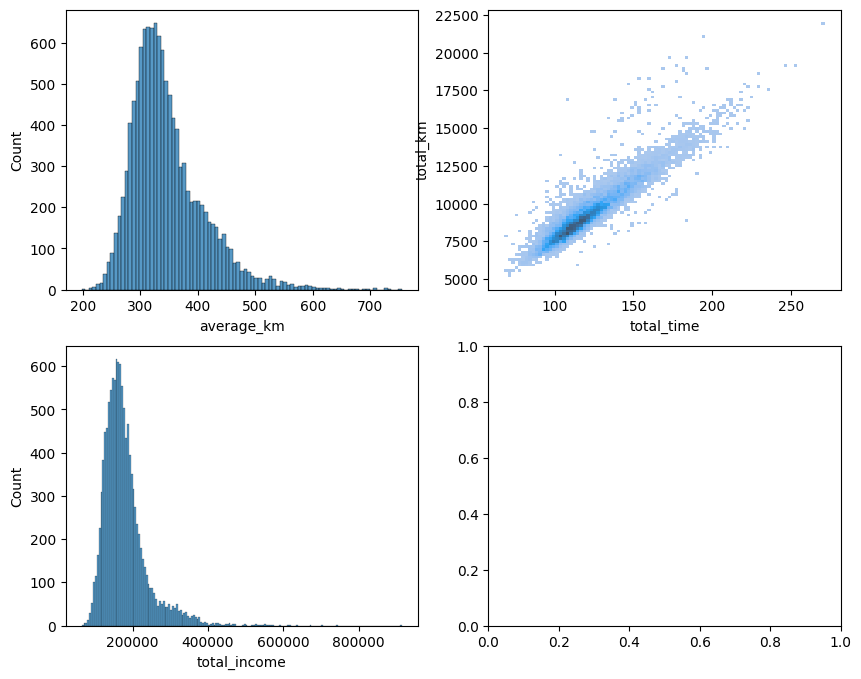

In [78]:
fig, axes = plt.subplots(2, 2, figsize=(10, 8))  # 2 rows, 1 column
sns.histplot(data=table,x="average_km", ax=axes[0,0])
sns.histplot(data=table,y="total_km",x="total_time",ax=axes[0,1])
sns.histplot(x="total_income", data=table, ax=axes[1,0])

In [81]:
df = trips_df
z_scores = (df['km'] - df['km'].mean()) / df['km'].std()
threshold = 1.5
df2 = df[abs(z_scores) <= threshold]


In [82]:
table2 = create_main_table(df2, taarif, drivers)

Processing income of drivers...


<Axes: xlabel='total_income', ylabel='Count'>

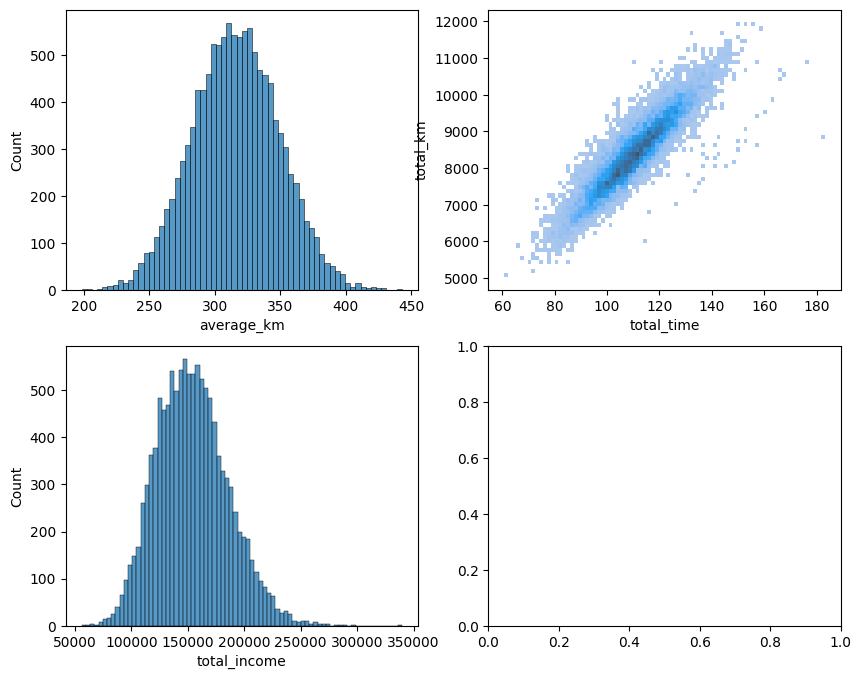

In [85]:
fig, axes = plt.subplots(2, 2, figsize=(10, 8))  # 2 rows, 1 column
sns.histplot(data=table2,x="average_km", ax=axes[0,0])
sns.histplot(data=table2,y="total_km",x="total_time",ax=axes[0,1])
sns.histplot(x="total_income", data=table2, ax=axes[1,0])

In [90]:
df_t30 = df[df["drive_time"] >30]
print("number of drives = ",len(df),", num drives over 30 hrs = ", len(df_t30), " = ",len(df_t30)/len(df))

number of drives =  324175 , num drives over 30 hrs =  3229  =  0.009960669391532352
